In [53]:
import os
os.chdir('C:/Users/ASUS/Desktop/Data Science/Capstone Project')

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
import seaborn as sns #for visualization
from plotly.offline import init_notebook_mode, iplot
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from collections import OrderedDict #to make sorted Dictionary

# Set a few plotting defaults
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['font.size'] = 15
plt.rcParams['patch.edgecolor'] = 'k'




# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [55]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [56]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [57]:
test['Target']=np.nan

# EDA and Data Cleaning

In [58]:
train.shape

(9557, 143)

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [60]:
train.select_dtypes(['object']).head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


We will use ID idhogar later. since idhogar is unique identification of each household. It is not need to be considered as problem feature

Dependency: Number of Household younger than 19 or older than 64.,head of household, yes=1 and no=0
edjefe: years of education of male head of household,based on escolari, yes=1,no=0
edjefa: years of education of female head of household,based on interaction of escolari, yes=1, no=0
Hence , we can replace yes and no with 1 and 0 respectively

In [61]:
#Converting Object DataType to Integer
train['dependency']=train['dependency'].replace(('yes','no'),(1,0)).astype(np.float64)
train['edjefe']=train['edjefe'].replace(('yes','no'),(1,0)).astype(np.float64)
train['edjefa']=train['edjefa'].replace(('yes','no'),(1,0)).astype(np.float64)
test['dependency']=test['dependency'].replace(('yes','no'),(1,0)).astype(np.float64)
test['edjefe']=test['edjefe'].replace(('yes','no'),(1,0)).astype(np.float64)
test['edjefa']=test['edjefa'].replace(('yes','no'),(1,0)).astype(np.float64)

In [62]:
train[['dependency','edjefe','edjefa']].describe()


,dependency,edjefe,edjefa
count,9557.000000,9557.000000,9557.000000
mean,1.149550,5.096788,2.896830
std,1.605993,5.246513,4.612056
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,6.000000,0.000000
75%,1.333333,9.000000,6.000000
max,8.000000,21.000000,21.000000


Now let's look at integer data types.


2     101
13      5
97      3
22      3
11      3
10      3
9       3
7       3
6       2
4       2
14      1
1       1
dtype: int64


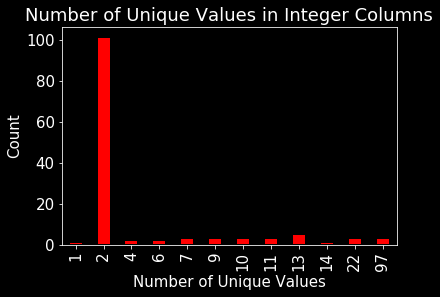

In [63]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='red',edgecolor='k',linewidth=2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Number of Unique Values in Integer Columns')
print(train.select_dtypes(np.int64).nunique().value_counts())
plt.show()

Maximum number of interger columns has 2 unique values which is boolean values . This boolean expression is on household level. Since, we need final prediction on household level, we will not need these boolean columns to aggregate. However, boolean expressions on individual level is needed to be aggregated.

# Exploring Label Distribution

There are four possible integer levels describing about Poverty levels. 1: extreme poverty,2:moderate poverty,3:vulnerable poverty,4: non-vulnerable poverty. We need to optimally assign poverty level to household than individuals.i.e. ['parentsco1']==1 has to be considered as household head and indicate poverty data of ['idhogar'] rather that different poverty data for each individual in same houshold.

Let's see distribution of training labels

To make optimal analysis of this dataset, let's first combine train and test dataset

In [64]:
data=pd.concat([train,test],axis=0)

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64


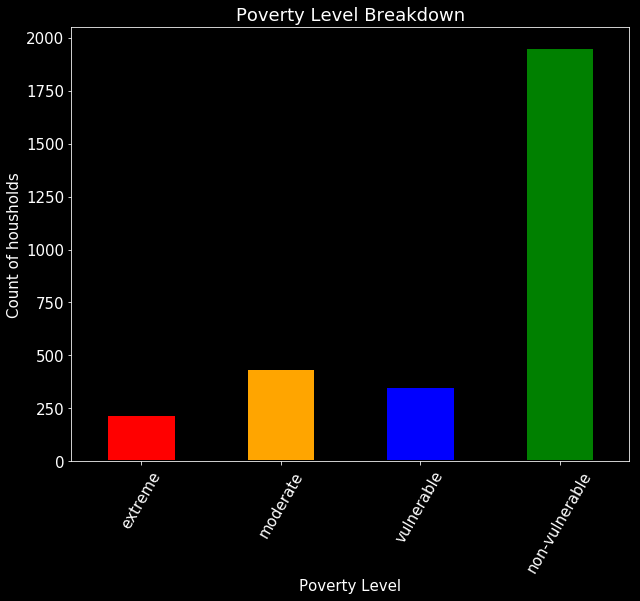

In [65]:
head=data.loc[data['parentesco1']==1].copy()

#Labels
labels=data.loc[(data['Target'].notnull()) & (data['parentesco1']==1),['Target','idhogar']]

#Value counts of Target
label_counts=labels['Target'].value_counts().sort_index()

# color mapping
colors=OrderedDict({1:'red',2:'orange',3:'blue',4:'green'})
poverty_mapping=OrderedDict({1:'extreme',2:'moderate',3:'vulnerable',4:'non-vulnerable'})

#visualization of labels distribution
label_counts.plot.bar(figsize=(10,8),color=colors.values(),edgecolor='k',linewidth=3)

#Formatting x-axis and y-axis
plt.xlabel('Poverty Level')
plt.ylabel('Count of housholds')
plt.xticks([x-1 for x in poverty_mapping.keys()],list(poverty_mapping.values()),rotation=60)
plt.title('Poverty Level Breakdown')
print(label_counts)
plt.show()

The problem with this label distribution is imbalance class. The number of households considered non-vulnerable is more than number of household in other poverty indicators. 
This imbalanced distribution may later led to classification problem while designing machine learning model. This may lead to inaccurate predictions. We have to address this issue.

# Wrong Labels

The other major issue which is needed to be addressed is to see that poverty targets are assigned on basis of households and not basis of individuals. If individuals within same [idhogar] is assigned different [Target] labels, we have to correct it, as according to requirement of this question, poverty of household is defined according to poverty label of household head i.e. [parentesco1].

Let's work on this and find equal and non-equal individual poverty labels of individuals in same households

In [66]:
#group by household id and see target label of each individual in household
#categorise into equal labels and non-equal labels
equal_labels=train.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)

non_equal_labels=equal_labels[equal_labels ==False]
print('There are {} number of houselholds who have different target labels'.format(len(non_equal_labels)))

There are 85 number of houselholds who have different target labels


In [67]:
#Example
train[train['idhogar'] == non_equal_labels.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


The summary of this problem demanded that we should define household income target according to head of household target variable i.e. [parentesco1]. In above example head of household has poverty target as 3 while 2 members of same household has different target. We have to correct it by replacing target variables of individual with target variable of head.


# Head of Household

Another major discrepancy which is in this dataset is that many families does not have assigned head of households. Let's find out how many such households exists.

In [68]:
head_household=train.groupby('idhogar')['parentesco1'].sum()
no_head=train.loc[train['idhogar'].isin(head_household[head_household==0].index),:]
print('No. of households with no head are {}'.format(no_head['idhogar'].nunique()))

No. of households with no head are 15


Now, let's analyze labels of households with no heads

In [69]:
no_head_label=no_head.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)
print('{} Households with no head have different labels.'.format(sum(no_head_label == False)))

0 Households with no head have different labels.


Thus there households with no heads assigned, have same Target values

Now, equalizing Target variables for all members of household with different Target variables as that of Head of household.

In [70]:
for household in non_equal_labels.index:
    #find correct label
    true_target=int(train[(train['idhogar']==household) &(train['parentesco1']==1)]['Target'])
    
    #set correct label for all member of household
    train.loc[train['idhogar']==household,'Target']=true_target
    
#Check if changes has been implemented
all_equal=train.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)

not_equal=all_equal[all_equal==False]

print('No of household with different Target variables are {}'.format(len(not_equal)))

No of household with different Target variables are 0


Now, all households has similar Target poverty levels.

# Working on Missing Values

In [71]:
train.isnull().sum().sort_values(0,ascending=False).to_frame().head(10)

,0
rez_esc,7928
v18q1,7342
v2a1,6860
meaneduc,5
SQBmeaned,5
techozinc,0
techoentrepiso,0
techocane,0
techootro,0
cielorazo,0


There are 5 major Features which has missing values. Let's explore them

rez_esc: Years behind in school

In [72]:
print(data.loc[data['rez_esc'].notnull()]['age'].describe())
print(train.loc[train['rez_esc'].notnull()]['age'].describe())


count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64
count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64


Description of non null data shows that school going children are between 7 and 19 years of age.
Let's explore null data

In [73]:
print(data.loc[data['rez_esc'].isnull()]['age'].describe())
print(train.loc[train['rez_esc'].isnull()]['age'].describe())

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64
count    7928.000000
mean       38.833249
std        20.989486
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64


Null data shows that minimum age of null data is 0 and maximum age is 97. According to description of problem,anyone below age of 0 and above age of 17 is non school going person. Let's replace this data with 0.

In [74]:
data.loc[((data['age']<7 )| (data['age']>17))&(data['rez_esc'].isnull()),'rez_esc']=0
train.loc[((train['age']<7 )| (train['age']>17))&(train['rez_esc'].isnull()),'rez_esc']=0

In [75]:
data['missing_value']=data['rez_esc'].isnull()
train['missing_value']=train['rez_esc'].isnull()


In [76]:
#explore any data anamoly
data['rez_esc'].describe()


count    33408.00000
mean         0.07591
std          0.68119
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max         99.00000
Name: rez_esc, dtype: float64

Now there is an issue here. Maximum value of rez_esc according to problem description has to be 5. However, this dataset has maximum value of 99. Let's replace all values above 5 to be 5

In [77]:
data.loc[data['rez_esc']>5,'rez_esc']=5
train.loc[train['rez_esc']>5,'rez_esc']=5


## v18q1

v18q1 descibes number of tablets in houehold

nan value in tablet column can be assumed as that househlod does not have a tablet an thus replace it by 0.


In [78]:
data['v18q1']=data['v18q1'].fillna(0)
train['v18q1']=train['v18q1'].fillna(0)

## v2a1

v2a1: Monthly rent payment

In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of tipovivi_, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a nan for the monthyl rent payment.

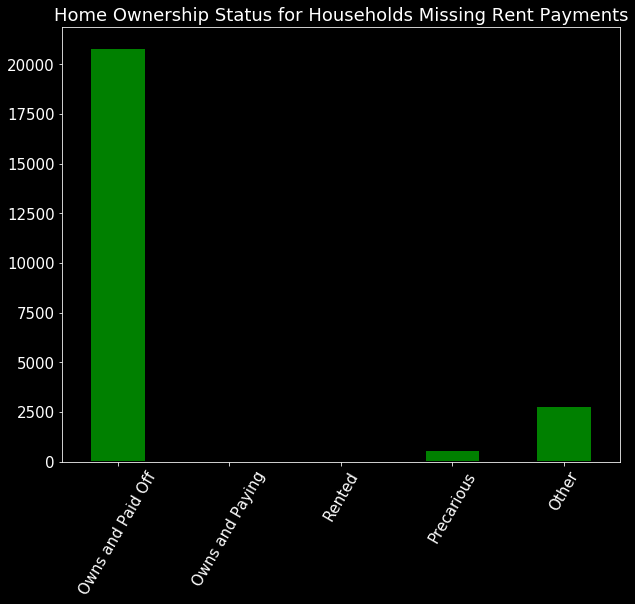

In [79]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

In [80]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

The meaning of the home ownership variables is below:

tipovivi1, =1 own and fully paid house
tipovivi2, "=1 own,  paying in installments"
tipovivi3, =1 rented
tipovivi4, =1 precarious
tipovivi5, "=1 other(assigned,  borrowed)"


We've solved the issue! Well, mostly: the households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information.

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

Number of households in train dataset with null values is equal to owning a house

In [81]:
train['v2a1'].isna().sum()

6860

In [82]:
sum_tipo=train['tipovivi1'].sum()+train['tipovivi2'].sum()+train['tipovivi4'].sum()+train['tipovivi5'].sum()

In [83]:
rent_miss=train.loc[(train['tipovivi2']==1)&(train['v2a1'].notna()),:].shape[0]

In [84]:
sum_tipo-rent_miss

6860

In [85]:
rent_miss

961

From the data it can be derived that missing value in 'v2a1' is due to people owning house,or for other precarious reason not known . Out of households who own a household on installments, 961 households also hold a house on rent

In [86]:
train.loc[(train['tipovivi1']==1)&(train['v2a1'].isna()),'v2a1']=0
data.loc[(data['tipovivi1'] == 1) & (data['v2a1'].isna()), 'v2a1'] = 0
train.loc[(train['tipovivi2']==1)&(train['v2a1'].isna()),'v2a1']=0
data.loc[(data['tipovivi2']==1)&(data['v2a1'].isna()),'v2a1']=0
train.loc[(train['tipovivi4']==1)&(train['v2a1'].isna()),'v2a1']=0
data.loc[(data['tipovivi4']==1)&(data['v2a1'].isna()),'v2a1']=0
train.loc[(train['tipovivi5']==1)&(train['v2a1'].isna()),'v2a1']=0
data.loc[(data['tipovivi5']==1)&(data['v2a1'].isna()),'v2a1']=0

In [87]:
train['v2a1'].isna().sum()

0

# Finding Outliers

Inter-quartile range(IQR) is used to identify outliers in the dataset. IQR is the difference between the 75th and 25th percentile of the data. It is measure of dispersion along the lines of standard deviation. During this analysis, features were found which had incosistent values like integer and boolean string (yes/no) mixed together. These needs to be removed and is the main focus of the next step.

In [88]:
for cols in data.columns[1:]:
    if cols in ['idhogar', 'dependency', 'edjefe', 'edjefa']:
        continue
    percentile75 = np.percentile(data[cols].fillna(0), 75)
    percentile25 = np.percentile(data[cols].fillna(0), 25)
    threshold = (percentile75 - percentile25) * 1.5
    lower, upper = (percentile25 - threshold), (percentile75 + threshold)
    # identify outliers
    outliers = data.loc[(data[cols] < lower) & (data[cols] > upper)]
    if len(outliers) > 0:
        print('Feature: {}. Identified outliers: {}'.format(cols, len(outliers)))
for cols in train.columns[1:]:
    if cols in ['idhogar', 'dependency', 'edjefe', 'edjefa']:
        continue
    percentile75 = np.percentile(train[cols].fillna(0), 75)
    percentile25 = np.percentile(train[cols].fillna(0), 25)
    threshold = (percentile75 - percentile25) * 1.5
    lower, upper = (percentile25 - threshold), (percentile75 + threshold)
    # identify outliers
    outliers = train.loc[(train[cols] < lower) & (train[cols] > upper)]
    if len(outliers) > 0:
        print('Feature: {}. Identified outliers: {}'.format(cols, len(outliers)))

# Feature Engineering

Creating Ordinal Variable
I'm going to compress these four variables into one by creating an ordinal variable. I'm going to choose the mapping myself, based on the data decriptions:

0: No electricity
1: Electricity from cooperative
2: Electricity from CNFL, ICA, ESPH/JASEC
3: Electricity from private plant

An ordered variable has an inherent ordering, and for this we choose our own based on the domain knowledge. After we create this new ordered variable, we can drop the four others. There are several households that do not have a variable here, so we will use a nan (which will be filled in during imputation) and add a Boolean column indicating there was no measure for this variable.

In [115]:
elec = []

# Assign values
for i, row in head.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
head['elec'] = elec
head['elec-missing'] = head['elec'].isnull()

# Remove the electricity columns
head = head.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

The final redundant column is area2. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.



In [116]:
heads = head.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

Creating Ordinal Variables
For the walls, roof, and floor of the house, there are three columns each: the first indicating 'bad', the second 'regular', and the third 'good'. We could leave the variables as booleans, but to me it makes more sense to turn them into ordinal variables because there is an inherent order: bad < regular < good. To do this, we can simply find whichever column is non-zero for each household using np.argmax.

Once we have created the ordinal variable, we are able to drop the original variables.

In [117]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# Feature Construction

In addition to mapping variables to ordinal features, we can also create entirely new features from the existing data, known as feature construction. For example, we can add up the previous three features we just created to get an overall measure of the quality of the house's structure.

In [124]:
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']



In [125]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


The next variable will be a warning about the quality of the house. It will be a negative value, with -1 point each for no toilet, electricity, floor, water service, and ceiling.

In [126]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

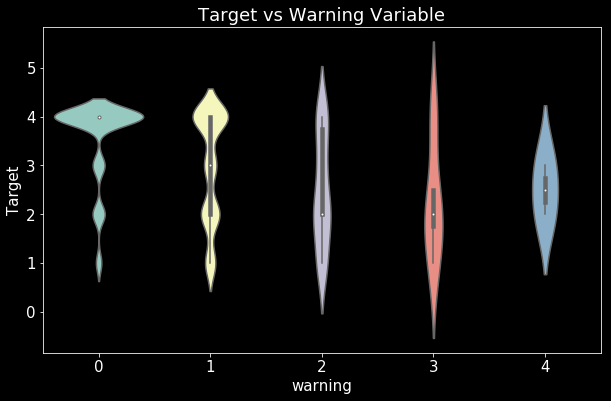

In [127]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'warning', y = 'Target', data = heads);
plt.title('Target vs Warning Variable');

The violinplot is not great here because it smooths out the categorical variable with the effect that it looks as if the Target can take on lesser and greater values than in reality. Nonetheless, we can see a high concentration of households that have no warning signs and have the lowest level of poverty. It looks as if this may be a useful feature, but we can't know for sure until we get to modeling!

The final household feature we can make for now is a bonus where a family gets a point for having a refrigerator, computer, tablet, or television.

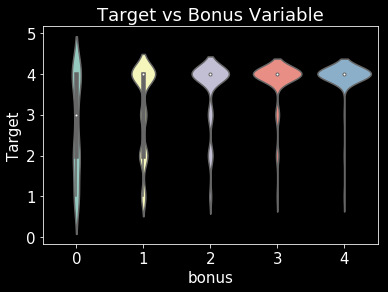

In [129]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Bonus Variable');

# Correlation

In [130]:
# Use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  SQBhogar_nin -0.256824
4  overcrowding -0.234954

Most positively correlated variables:
              feature     pcorr
121       SQBescolari  0.314397
122  walls+roof+floor  0.332446
123          meaneduc  0.333652
124          escolari  0.333791
125            Target  1.000000


For the negative correlations, as we increase the variable, the Target decreases indicating the poverty severity increases. Therefore, as the warning increases, the poverty level also increases which makes sense because this was meant to show potential bad signs about a house. The hogar_nin is the number of children 0 - 19 in the family which also makes sense: younger children can be financial source of stress on a family leading to higher levels of poverty. Or, families with lower socioeconomic status have more children in the hopes that one of them will be able to succeed. Whatever the explanation, there is a real link between family size and poverty

On the other hand, for the positive correlations, a higher value means a higher value of Target indicating the poverty severity decreases. The most highly correlated household level variable is meaneduc, the average education level of the adults in the household. This relationship between education and poverty intuitively makes sense: greater levels of education generally correlate with lower levels of poverty. We don't necessarily know which causes which, but we do know these tend to move in the same direction.

The general guidelines for correlation values are below, but these will change depending on who you ask (source for these):

.00-.19 “very weak”
.20-.39 “weak”
.40-.59 “moderate”
.60-.79 “strong”
.80-1.0 “very strong”
What these correlations show is that there are some weak relationships that hopefully our model will be able to use to learn a mapping from the features to the Target.

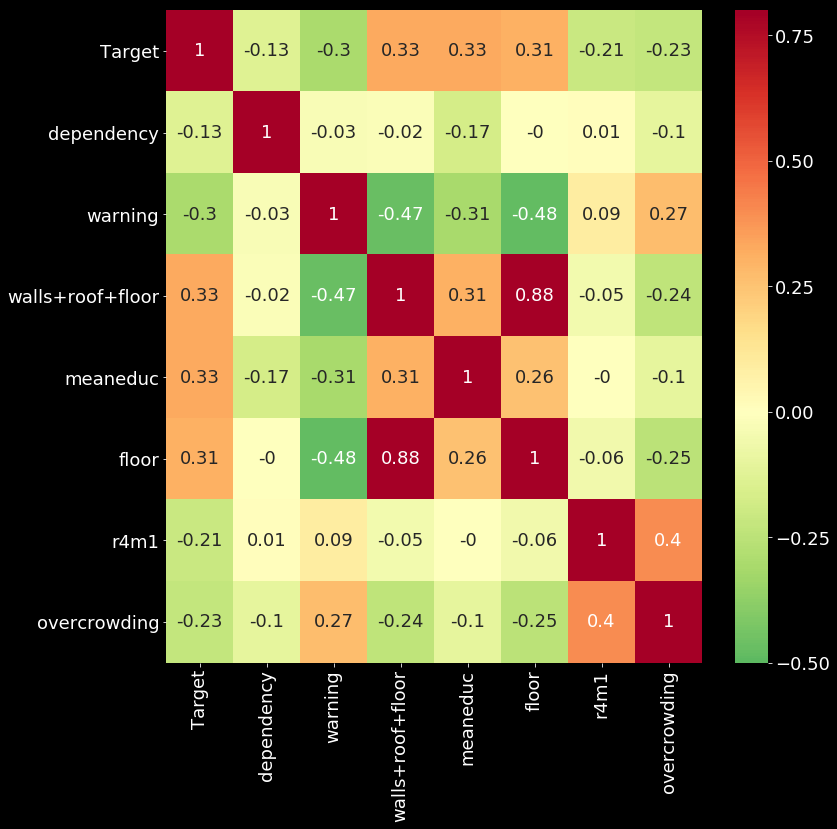

In [131]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

# Exploring Individual Variables

There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering).

In [135]:
id_ = ['Id', 'idhogar', 'Target']
ind_bool = ['v18q', 'dis', 'male', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone']

ind_ordered = ['rez_esc', 'escolari', 'age']


ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 38)

In [136]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

[]

In [137]:
ind = ind.drop(columns = 'male')

# Creating Ordinal Variables

Much as we did with the household level data, we can map existing columns to an ordinal variable. Here we will focus on the instlevel_ variables which indicate the amount of education an individual has from instlevel1: no level of education to instlevel9: postgraduate education.

To create the ordinal variable, for each individual, we will simply find which column is non-zero. The education has an inherent ordering (higher is better) so this conversion to an ordinal variable makes sense in the problem context.

In [138]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [139]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

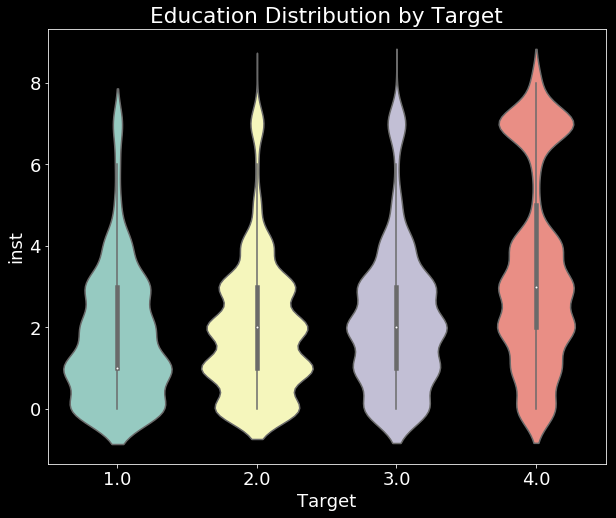

In [140]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

Higher levels of education seem to correspond to less extreme levels of poverty. We do need to keep in mind this is on an individual level though and we eventually will have to aggregate this data at the household level.

In [141]:
# Drop the education columns
ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 29)

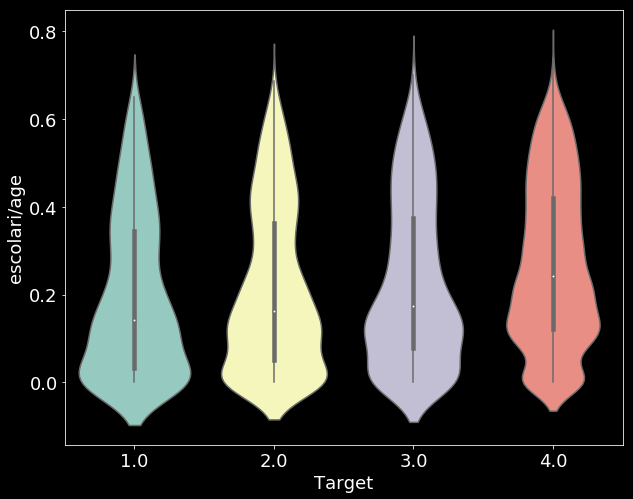

In [142]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

We can also take our new variable, inst, and divide this by the age. The final variable we'll name tech: this represents the combination of tablet and mobile phones.

In [143]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

## Feature Engineering through Aggregations

In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to groupby the family id idhogar and then agg the data. For the aggregations for ordered or continuous variables, we can use six, five of which are built in to pandas, and one of which we define ourselves range_. The boolean aggregations can be the same, but this will create many redundant columns which we will then need to drop. For this case, we'll use the same aggregations and then go back and drop the redundant columns.

In [145]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...  inst/age  \
           min max sum count  std range_ min max sum count  ...       sum   
idhogar                                                     ...             
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...  0.483333   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...  0.016667   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...  0.511959   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...  0.184211   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...  0.213768   

                                    tech                            
          count       std    range_  min max sum count  std range_  
idhogar                                                             
000a08204     3  0.139775  0.250000    2   2   6     3  0.0      0  
000bce7c4     2  0.011785  0.016667    1   1   2     2  0.0      0  
001845fb0     4  0.060123  0.128205    1   1   4     4  0.0      0  
001ff74ca     1       NaN  0.000000    2   2   4     2  0.0      0  
003123ec2     4  0.064636  0.130435    1   1   4     4  0.0      0  

[5 rows x 174 columns]

In [146]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.184211,1,NaN,0.000000,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.213768,4,0.064636,0.130435,1,1,4,4,0.0,0


In [147]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 317)


In [148]:
final.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,0.069767,1,NaN,0.000000,1,1,1,1,NaN,0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,0.104478,1,NaN,0.000000,2,2,2,1,NaN,0
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,0.043478,1,NaN,0.000000,0,0,0,1,NaN,0
3,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,...,0.514842,4,0.033010,0.071207,2,2,8,4,0.0,0
4,ID_1284f8aad,130000.0,1,2,0,1,1,0,NaN,0,...,0.333766,4,0.060063,0.142857,1,1,4,4,0.0,0


In [149]:
corrs = final.corr()['Target']

In [150]:
corrs.sort_values().head()

warning            -0.301791
hogar_nin          -0.266309
r4t1               -0.260917
SQBhogar_nin       -0.256824
estadocivil1-sum   -0.239130
Name: Target, dtype: float64

In [151]:
corrs.sort_values().dropna().tail()

meaneduc        0.333652
escolari        0.333791
inst-max        0.368229
escolari-max    0.373091
Target          1.000000
Name: Target, dtype: float64

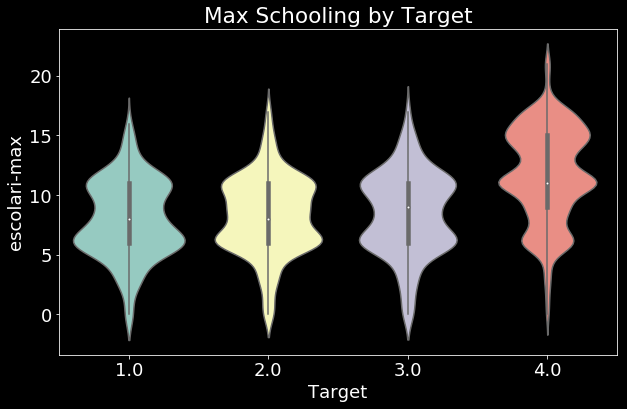

In [152]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

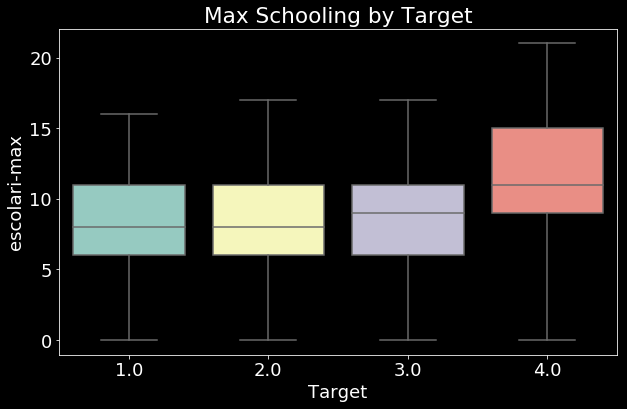

In [153]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

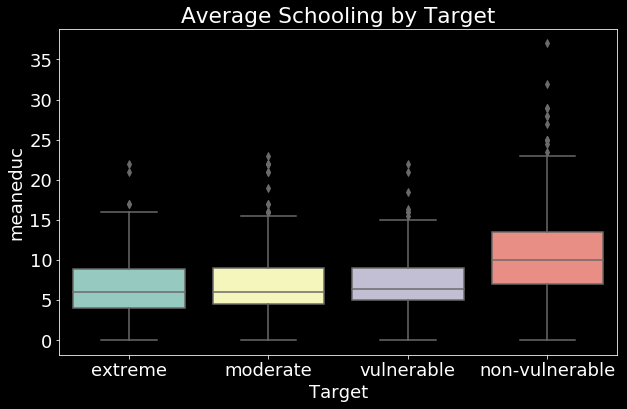

In [154]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Average Schooling by Target');

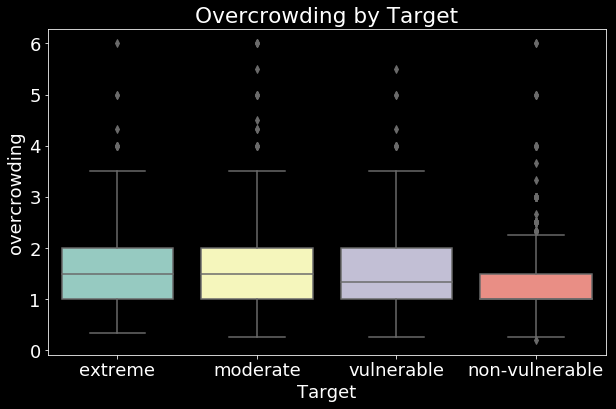

In [155]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Overcrowding by Target');

# Machine Learning Model

Once feature engineering/construction is done, we can get started with the machine learning! All of our data (both training and testing) is aggregated for each household and so can be directly used in a model. To first show the process of modeling, we'll use the capable Random Forest Classifier in Scikit-Learn. This probably won't get us to the top of the leaderboard, but it will allow us to establish a baseline. Later we'll try several other models including the powerful Gradient Boosting Machine.

To assess our model, we'll use 10-fold cross validation on the training data. This will essentially train and test the model 10 times using different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds. We use the F1 Macro measure to evaluate performance.

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [163]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

Because we are going to be comparing different models, we want to scale the features (limit the range of each column to between 0 and 1). For many ensemble models this is not necessary, but when we use models that depend on a distance metric, such as KNearest Neighbors or the Support Vector Machine, feature scaling is an absolute necessity. When comparing different models, it's always safest to scale the features. We also impute the missing values with the median of the feature.

For imputing missing values and scaling the features in one step, we can make a pipeline. This will be fit on the training data and used to transform the training and testing data.

In [164]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

In [165]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3441 with std = 0.0472
